In [12]:
using Pkg
Pkg.activate("./MISAEM")

# Display the status of the current environment
Pkg.status()

  Activating project at `~/Documents/Code/misaem_julia/MISAEM`


Project MISAEM v0.1.0
Status `~/Documents/Code/misaem_julia/MISAEM/Project.toml`
⌃ [31c24e10] Distributions v0.25.120
  [7073ff75] IJulia v1.30.5
  [91a5bcdd] Plots v1.41.1
  [92933f4c] ProgressMeter v1.11.0
  [10745b16] Statistics v1.11.1
  [37e2e46d] LinearAlgebra v1.11.0
  [9a3f8284] Random v1.11.0
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [13]:
using MISAEM
using Random
using Distributions
using LinearAlgebra
using Statistics

# Set a random seed for reproducibility
Random.seed!(123)

# 2. Generate some example data
# n: number of samples, p: number of features
n = 100000
p = 10

# Create a design matrix X with some missing values (NaN)
X_complete = rand(Normal(), n, p)
X_missing = copy(X_complete)
X_missing[rand(Bool, n, p) .< 0.15] .= NaN # Introduce 15% missing values

# Create a response vector y (binary)
true_coeffs = randn(p)
linear_predictor = X_complete[:, 1:p] * true_coeffs
probabilities = 1.0 ./ (1.0 .+ exp.(-linear_predictor))
y = rand.(Bernoulli.(probabilities));

println(probabilities[1:10])
println(y[1:10])
println(mean(y))

[0.06730891531105272, 0.9978150690749745, 0.9937920987101224, 0.14041104037283866, 0.21683353891026555, 0.3068098912510201, 0.40025805805444076, 0.9782695467930898, 0.9867785764654529, 0.7786549589529347]
Bool[1, 1, 1, 0, 1, 1, 0, 1, 1, 0]
0.4996


In [14]:


# 3. Instantiate the MISAEM model
# You can adjust hyperparameters here if needed
model = MISAEM.SAEMLogisticRegression(
    maxruns = 1000,
    random_state = 42,
    var_cal=false,
    ll_obs_cal=false
)


SAEMLogisticRegression(1000, 1.0e-7, 2, 1.0, 50, false, false, nothing, 42, Float64[], 0.0, Float64[], Float64[], Matrix{Float64}(undef, 0, 0), 0.0, false, 0)

In [15]:

# 4. Fit the model to the data
println("Fitting the model...")
MISAEM.fit!(model, X_missing, y)


Fitting the model...


┌ Warning: 83 rows with all NaN values in X have been removed.
│   DataRemovalWarning = MISAEM.DataRemovalWarning
└ @ MISAEM ~/Documents/Code/misaem_julia/MISAEM/src/MISAEM.jl:121
SAEM Iterations:  11%|███▉                              |  ETA: 0:01:15


...converged after 115 iterations.


SAEMLogisticRegression(1000, 1.0e-7, 2, 1.0, 50, false, false, nothing, 42, [0.0015501017645185894, 0.08734030169783273, 0.1733266906945221, 0.9970947278124604, -0.7358198165674381, -0.3601852347804181, -0.6838589172237697, -2.0832967346135716, -0.13224277762559267, -0.602813433688797, 1.5168470670258325], 0.0015501017645185894, Float64[], [0.005068749638413888, 0.00255394299395685, -0.0035758566729687416, -0.009731463103177278, -0.0015971270531946722, -0.0012490129639219744, -0.00012012399305759831, 0.0006696221150850239, 0.00012692469794931598, -0.006486528984219806], [0.9924152188162448 -0.003030845499618893 … 0.008788852306225477 -0.0022158532417308327; -0.003030845499618893 0.9858750300715614 … -0.005367044864254929 -0.011840549809775586; … ; 0.008788852306225477 -0.005367044864254929 … 1.0012910435324667 0.007988362527491398; -0.0022158532417308327 -0.011840549809775586 … 0.007988362527491398 0.9923055573719597], 0.0, true, 115)

In [16]:

# 5. Display the results
println("\nFitting complete.")
println("Converged: ", model.converged)
println("Number of iterations: ", model.n_iterations)
println("Estimated Coefficients (including intercept):")
println(model.coef)
println("Observed Log-Likelihood: ", model.ll_obs)

# 6. Make predictions on the training data
println("\nMaking predictions...")
predictions = MISAEM.predict(model, X_missing)
probabilities = MISAEM.predict_proba(model, X_missing, method=:map)

println("Prediction for the first 5 samples: ", predictions[1:5])
println("Probabilities for the first 5 samples: ", probabilities[1:5, :])


Fitting complete.
Converged: true
Number of iterations: 115
Estimated Coefficients (including intercept):
[0.0015501017645185894, 0.08734030169783273, 0.1733266906945221, 0.9970947278124604, -0.7358198165674381, -0.3601852347804181, -0.6838589172237697, -2.0832967346135716, -0.13224277762559267, -0.602813433688797, 1.5168470670258325]
Observed Log-Likelihood: 0.0

Making predictions...


┌ Warning: 83 rows with all NaN values in X have been removed.
│   DataRemovalWarning = MISAEM.DataRemovalWarning
└ @ MISAEM ~/Documents/Code/misaem_julia/MISAEM/src/MISAEM.jl:121
┌ Warning: 83 rows with all NaN values in X have been removed.
│   DataRemovalWarning = MISAEM.DataRemovalWarning
└ @ MISAEM ~/Documents/Code/misaem_julia/MISAEM/src/MISAEM.jl:121


Prediction for the first 5 samples: [0, 1, 1, 1, 1]
Probabilities for the first 5 samples: [0.8246318816569875 0.1753681183430125; 0.0125386105684 0.9874613894316; 0.16698366113067964 0.8330163388693204; 0.4575928874396509 0.5424071125603491; 0.38280966183956433 0.6171903381604357]


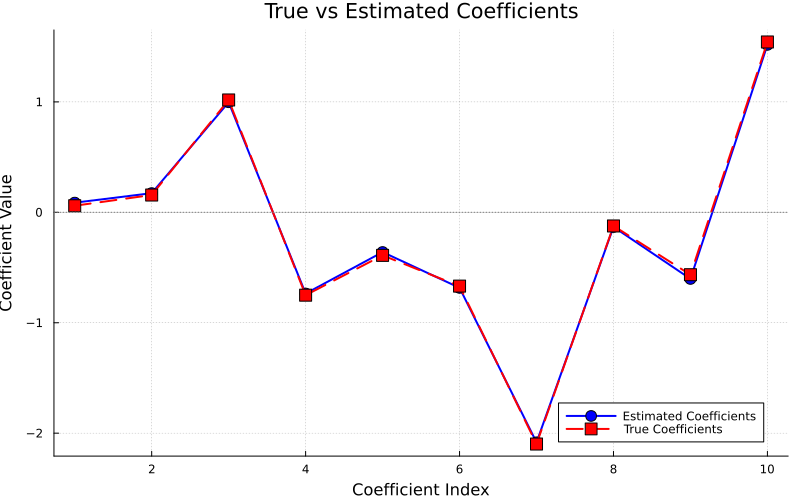


Coefficient Comparison Summary
Index | True Coef | Estimated | Difference | Rel. Error %
------------------------------------------------------------

Overall Performance Metrics:
  Mean Squared Error (MSE):  0.000516
  Mean Absolute Error (MAE): 0.02114
  Correlation:               0.999747


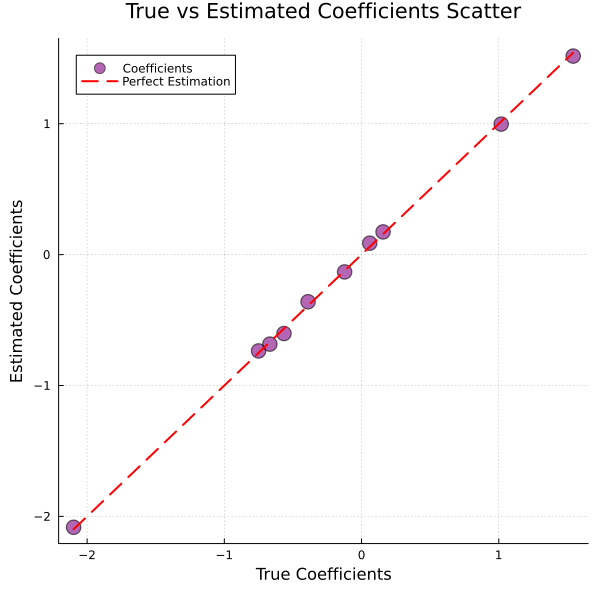

In [17]:
using Plots

# Extract estimated coefficients (excluding intercept)
# Assuming model.coef has intercept as first element
estimated_coefs = model.coef[2:end]  # Skip intercept
n_coefs = length(estimated_coefs)

# Create coefficient indices
coef_indices = 1:n_coefs

# If your model calculates variance, you can get confidence intervals
# Otherwise, we'll create a simple comparison plot
if hasfield(typeof(model), :coef_std) && !isnothing(model.coef_std)
    # With confidence intervals
    coef_std = model.coef_std[2:end]  # Skip intercept std
    ci_lower = estimated_coefs .- 1.96 .* coef_std
    ci_upper = estimated_coefs .+ 1.96 .* coef_std
    
    # Create plot with confidence intervals
    p = plot(coef_indices, estimated_coefs, 
             label="Estimated Coefficients",
             marker=:circle, 
             markersize=6,
             linewidth=2,
             color=:blue,
             xlabel="Coefficient Index",
             ylabel="Coefficient Value",
             title="True vs Estimated Coefficients with 95% CI",
             legend=:best,
             size=(800, 500))
    
    # Add confidence interval ribbons
    plot!(p, coef_indices, estimated_coefs,
          ribbon=(estimated_coefs .- ci_lower, ci_upper .- estimated_coefs),
          fillalpha=0.3,
          fillcolor=:blue,
          label="95% CI",
          linewidth=0)
else
    # Without confidence intervals - simple comparison
    p = plot(coef_indices, estimated_coefs, 
             label="Estimated Coefficients",
             marker=:circle, 
             markersize=6,
             linewidth=2,
             color=:blue,
             xlabel="Coefficient Index",
             ylabel="Coefficient Value",
             title="True vs Estimated Coefficients",
             legend=:best,
             size=(800, 500))
end

# Add true coefficients
plot!(p, coef_indices, true_coeffs,
      label="True Coefficients",
      marker=:square,
      markersize=6,
      linewidth=2,
      color=:red,
      linestyle=:dash)

# Add a horizontal line at y=0 for reference
hline!(p, [0], color=:gray, linestyle=:dot, label="", linewidth=1)

# Add grid for better readability
plot!(p, grid=true, gridstyle=:dot, gridalpha=0.3)

display(p)

# Print comparison statistics
println("\n" * "="^60)
println("Coefficient Comparison Summary")
println("="^60)
println("Index | True Coef | Estimated | Difference | Rel. Error %")
println("-"^60)
for i in 1:n_coefs
    diff = estimated_coefs[i] - true_coeffs[i]
    rel_error = abs(diff / true_coeffs[i]) * 100
end
println("="^60)

# Calculate overall metrics
mse = mean((estimated_coefs .- true_coeffs).^2)
mae = mean(abs.(estimated_coefs .- true_coeffs))
correlation = cor(true_coeffs, estimated_coefs)

println("\nOverall Performance Metrics:")
println("  Mean Squared Error (MSE):  ", round(mse, digits=6))
println("  Mean Absolute Error (MAE): ", round(mae, digits=6))
println("  Correlation:               ", round(correlation, digits=6))
println("="^60)

# Optional: Create a scatter plot comparing true vs estimated
p2 = scatter(true_coeffs, estimated_coefs,
             xlabel="True Coefficients",
             ylabel="Estimated Coefficients",
             title="True vs Estimated Coefficients Scatter",
             label="Coefficients",
             marker=:circle,
             markersize=8,
             color=:purple,
             alpha=0.6,
             size=(600, 600))

# Add diagonal line (perfect estimation)
coef_range = [minimum([true_coeffs; estimated_coefs]), 
              maximum([true_coeffs; estimated_coefs])]
plot!(p2, coef_range, coef_range,
      label="Perfect Estimation",
      color=:red,
      linestyle=:dash,
      linewidth=2)

plot!(p2, grid=true, gridstyle=:dot, gridalpha=0.3)
display(p2)